In [2]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import itertools
from math import sqrt
from scipy.spatial import distance
from scipy.spatial import distance_matrix

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [3]:
# Download Data -- run this cell only one time per runtime
!gdown 1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
!unzip "/content/Part1_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part1_data/matches.mat')
r1 = data['r1']
r2 = data['r2']
c1 = data['c1']
c2 = data['c2']
matches = data['matches']

Downloading...
From: https://drive.google.com/uc?id=1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
To: /content/Part1_data.zip
100% 157k/157k [00:00<00:00, 65.9MB/s]
Archive:  /content/Part1_data.zip
   creating: /content/Part1_data/
  inflating: /content/Part1_data/chapel00.png  
  inflating: /content/Part1_data/chapel01.png  
  inflating: /content/Part1_data/matches.mat  


In [4]:
# Load Keypoints
x1 = c1[matches[:,0]-1]
y1 = r1[matches[:,0]-1]
x2 = c2[matches[:,1]-1]
y2 = r2[matches[:,1]-1]

In [5]:
# Download Data -- run this cell only one time per runtime
!gdown 1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
!unzip "/content/hill.zip" -d "/content/hill"

!gdown 1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
!unzip "/content/tv.zip" -d "/content/tv"


Downloading...
From: https://drive.google.com/uc?id=1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
To: /content/hill.zip
100% 205k/205k [00:00<00:00, 98.4MB/s]
Archive:  /content/hill.zip
  inflating: /content/hill/1.JPG     
  inflating: /content/hill/2.JPG     
  inflating: /content/hill/3.JPG     
Downloading...
From: https://drive.google.com/uc?id=1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
To: /content/tv.zip
100% 130k/130k [00:00<00:00, 84.8MB/s]
Archive:  /content/tv.zip
  inflating: /content/tv/1.jpg       
  inflating: /content/tv/2.jpg       
  inflating: /content/tv/3.jpg       


## Helper Functions

In [146]:
#Reading Hill images
hill1=cv2.cvtColor(cv2.imread("/content/hill/1.JPG"),cv2.COLOR_BGR2RGB)
hill1=cv2.imread("/content/hill/1.JPG")
hill2=cv2.cvtColor(cv2.imread("/content/hill/2.JPG"),cv2.COLOR_BGR2RGB)
hill3=cv2.cvtColor(cv2.imread("/content/hill/3.JPG"),cv2.COLOR_BGR2RGB)
#Reading TV images
TV1=cv2.cvtColor(cv2.imread("/content/tv/1.jpg"),cv2.COLOR_BGR2RGB)
TV2=cv2.cvtColor(cv2.imread("/content/tv/2.jpg"),cv2.COLOR_BGR2RGB)
TV3=cv2.cvtColor(cv2.imread("/content/tv/3.jpg"),cv2.COLOR_BGR2RGB)

# Affine Structure from Motion

## Overview
<img src="https://drive.google.com/uc?id=1nYd0eJjBtVIPuapfxuiVzswjswGN_Gq2&export=download" width="800"/>


This problem continues the interest point detection and tracking problem from HW2. Now, you will recover a 3D pointcloud from the image sequence hotel.seq0.png … hotel.seq50.png. You are encouraged to use your results from HW2, but in case you were not able to complete it, we have also included pre- computed intermediate results in the supplemental material. Submit your code so that we can reproduce your results.

The outline of the affine structure from motion algorithm:

<img src="https://drive.google.com/uc?id=1BSvHwRR5gNBwDGlrk-dcLCRcuIAvab__&export=download" width="700"/>


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [177]:
# Download Data -- run this cell only one time per runtime
!gdown 1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
!unzip "/content/Part2_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part2_data/tracks.mat')

Downloading...
From: https://drive.google.com/uc?id=1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
To: /content/Part2_data.zip
100% 5.44M/5.44M [00:00<00:00, 102MB/s]
Archive:  /content/Part2_data.zip
replace /content/Part2_data/images/hotel.seq0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Code

Look here (500, 51)
(102, 3) (3, 400)
(51, 3)


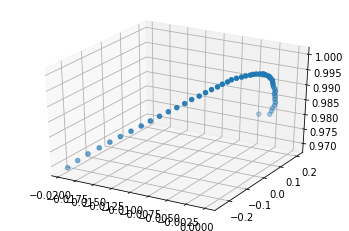

<Figure size 7200x7200 with 0 Axes>

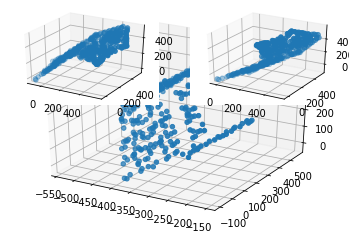

<Figure size 7200x7200 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [256]:
from mpl_toolkits import mplot3d
from scipy.ndimage.measurements import mean
from scipy.linalg import sqrtm
%matplotlib inline
ax = plt.axes(projection='3d')
track_x = data['track_x']
track_y = data['track_y']
index_list=[]

# Remove the nan values (i.e,points which went out of frame)
'''
For removing NANS the we remove the pair (x,y) if any one or both of the x coordinate 
or y coordinate is out of the scene/ NAN. Hence we need to find those indexes for which these happens
'''
print("Look here",track_y.shape)
y_points,scenes=track_y.shape
## 500*51
NAN_indexes=np.hstack([[track_x[:, idx], track_x[:, idx]] for idx in range(scenes)])
NAN_indexes=NAN_indexes.reshape((102, -1))
NANS= np.isnan(NAN_indexes)

Iterations=NAN_indexes.shape[1]
for i in range(Iterations):
  h = NANS[:,i].tolist()
  if not any(h):
    index_list.append(i)
track_x = track_x[index_list, :]
track_y = track_y[index_list, :]
  
def affineSFM(x, y):
  '''
  Function: Affine structure from motion algorithm
  % Normalize x, y to zero mean
  % Create measurement matrix
  D = [xn' ; yn'];
  % Decompose and enforce rank 3
  % Apply orthographic constraints
  '''
  # YOUR CODE HERE
  iteration=y.shape[1]
  x_n=x-mean(x)
  y_n=y-mean(y)
  x_nt=np.transpose(x_n)
  y_nt=np.transpose(y_n)
  # D= np.block([[x[:, i], y[:, i]] for i in range(y.shape[1])]).reshape((102, -1))
  D=np.concatenate([[x[:, i], y[:, i]] for i in range(y.shape[1])])
  D=D.reshape(102, -1)
  # U, S, VT = np.linalg.svd(D)
  U, W, VT = np.linalg.svd(D)
  U3 = U[:, :3]
  S3 = np.diag(W[:3])
  VT3 = VT[:3, :]
  S3_sqrt = sqrtm(S3)
  A_1=np.matmul(U3,S3_sqrt)
  X_1=np.matmul(S3_sqrt,VT3)
  S = []
  Iter= A_1.shape[0]
  for i in range(0,Iter, 2):
    point_1 =  A_1[i]
    point_2 = A_1[i+1]
    Z1 = np.matmul(np.expand_dims(point_1, axis=1),np.expand_dims(point_1, axis=0))
    Z1=Z1.reshape(1,9)
    Z2 =np.matmul(np.expand_dims(point_2, axis=1) , np.expand_dims(point_2, axis=0))
    Z2=Z2.reshape((1,9))
    Z3 =np.matmul (np.expand_dims(point_1, axis=1), np.expand_dims(point_2, axis=0))
    Z3=Z3.reshape((1,9))
    if i==0:
      mat = Z1
    else:
      mat = np.concatenate((mat, Z1), axis=0)
    mat = np.concatenate((mat, Z2), axis=0)
    mat = np.concatenate((mat, Z3), axis=0)
    S += [1,1,0]
  S = np.array(S)
  least = np.linalg.lstsq(mat, S, rcond=None)
  L = least[0].reshape((3,3))
  w, v = np.linalg.eig(L)
  C = np.linalg.cholesky(L)
  A=np.matmul(A_1,C)
  X = np.matmul(np.linalg.inv(C), X_1)
  return A, X

def visualize_structure(X):
  fig = plt.figure(figsize=(100,100))
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1, projection='3d')
  ax.scatter3D(X[0, :], X[1, :], X[2, :], X[2, :])
  ax = fig.add_subplot(2, 2, 2, projection='3d')
  ax.scatter3D(X[2, :], X[2, :], X[1, :],X[0,:])
  ax = fig.add_subplot(2, 2, 1, projection='3d')
  ax.scatter3D(X[1, :], X[2, :], X[2, :], X[0, :])
def camera_motion_visualize(A):
  for i in range(0, A.shape[0], 2):
    position = np.cross(A[i], A[i+1])
    mag = np.linalg.norm(position)
    norm_position = position / mag
    norm_position = np.expand_dims(norm_position, axis=0)
    if i==0:
      cam_motion = norm_position
    else:
      cam_motion = np.concatenate((cam_motion, norm_position), axis=0)
  print(cam_motion.shape)
  fig = plt.figure(figsize=(100,100))
  fig = plt.figure()
  ax.scatter3D(cam_motion[:, 0],cam_motion[:, 1], cam_motion[:, 2], cam_motion[:, 2], cmap='green')
 
  

A, X = affineSFM(track_x, track_y)
print(A.shape, X.shape)
visualize_structure(X)
# ax = fig.add_subplot(1, 2, 2, projection='3d')
camera_motion_visualize(A)

### Write-up 


*   Plot the predicted 3D locations of the tracked points for 3 different viewpoints. Choose the viewpoints so that the 3D structure is clearly visible.
*   Plot the predicted 3D path of the cameras. The camera position for each frame is given by the cross product a_k = a_i x a_j. Normalize a_k to be unit length for consistent results. Give 3 plots, one for each dimension of a_k 
<!-- We provide the function plotSfM.m for visualizing the recovered 3D shape and camera positions in each frame. -->


* 3d location view points
### on of the perspective
![picture](https://drive.google.com/uc?id=1noGjMmz8_5gzdSZm1g-DQhp9coz_R8-W)


### 3 perspectives
![picture](https://drive.google.com/uc?id=1_tsaUXIMjFtJ3sB8-ZE8pqj2GYBiovgj)

* 3d camera path 

![picture](https://drive.google.com/uc?id=1McHvHD3LAETeh0jl0oVt3T1fvidlUUey)




